# Multiclass classifiction

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame = False)
mnist.keys()

/home/barbra/Hands_on_ML/env/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']


In [4]:
import numpy as np
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
some_digit = X[0]

In [7]:
y[0]

5

Scikit-Learn detects when you use a binary classifer for a multiclass classification task and automatically runs OvO, One vs One classification.

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)


SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

It trained 10 binary classifiers, git their decsion scores  for the image and selected the class with the highest score

In [10]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

It returns 10 scores per instance with the higest score corresponding to 3.

In [11]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)

3
[0 1 2 3 4 5 6 7 8 9]


To force Scikit learn to use OvO or OvA, use the OneVsOneCalassifer or OneVsRestClassifier classes. Create an instance and pass binary classifier to its constructor.

In [12]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [13]:
ovo_clf.predict([some_digit])


array([5], dtype=uint8)

In [14]:
len(ovo_clf.estimators_)

45

Training a RandomForestClassifier:


In [15]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 100)
forest_clf.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
forest_clf.predict([some_digit])

array([5], dtype=uint8)

RandomForestClassifier can classifeier instances into maultiple classes.

In [17]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.02, 0.12, 0.  , 0.8 , 0.  , 0.01, 0.05, 0.  ]])

The classifier has 88 percent accuracy.

## Evaluating the Classifiers

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

The model gave accuracy above 85% for each iteration. We will scale the inputs to increase the accuracy.

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring= "accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

Using the prediction matrix we will analyze the types of erros our model makes.

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)


In [21]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Looking at image representation of the confusion matrix:

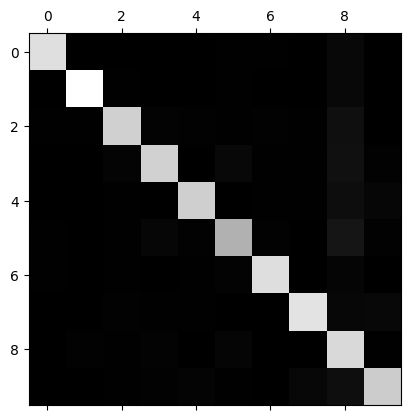

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Most images are in the main diagonal and hence were classified well. The darker the boxes the worse the classifers work on them. This shows that the class has less examples compared to the rest and thus the model will perform poorly on it.

To compare error rates, divide each value of the confusion matrix with the number of images in the corresponding class so you can compare error rates instead of absolute umber of errors.

In [23]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

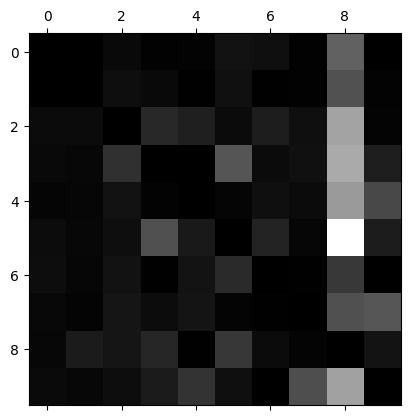

In [24]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

All rows represent actual classes while all columns represent predicted classes. Bright columns say that many images get misclassified into those classes(8 and 9). Bright rows say that the classes are often confused with other digits(8 and 9).
Darks rows show that most of the examples in the classes are classified correctly.
In the confusoin matrix, more effort should be spent on imporving the classification of 8s and 9s as well as fixing the specifit3/5 confusion.
soution: preprocessing the images, increasing the data of classes with less data, analysing individual errors(time consuming)

## Multilabel Classification

In [26]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

the code has tow targes labels for each didgit in the image. One states if is is large and the other dtates if the digit is odd. 

In [27]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [30]:
from sklearn.metrics import f1_score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

In [31]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [32]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'some_index' is not defined